# Code for loading in the datasets and modelling

In [31]:
from loader import list_files, Files, Folders  #precalculate what we are loading in
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof

## Load in data

In [32]:
class loaded:
    def __init__(self):
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/X_texture.npz") #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/y_texture.npz") #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys={}
        self.files=['wool', 'LacedMatt', 'Gfoam', 'bubble', 'Efoam', 'cotton', 'Flat', 'felt', 'Ffoam']
        for i, name in enumerate(self.files):
            self.keys[i]=name
        self.keys={16: 'cotton', 18: 'Ffoam', 11: 'Gfoam', 10: 'bubble', 17: 'Efoam', 14: 'jeans', 12: 'felt'}
        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
data=loaded()

Dataset size: 4800 
Window size: 20 
Image: (110, 120)
Memory needed: 1.18 GB


In [30]:
np.unique(data.y)

array([11, 14, 16, 20, 21, 22, 24, 26, 27], dtype=uint8)

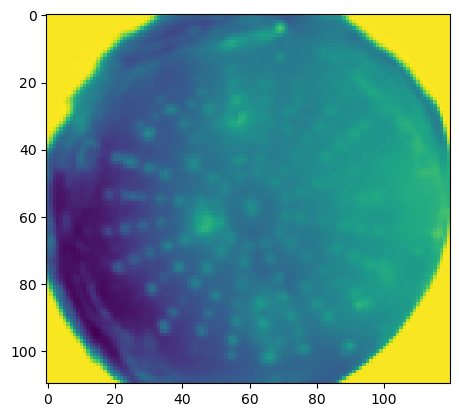

In [37]:
plt.imshow(data.X[0][0])
plt.show()

In [33]:
data.applySobel()

KeyError: 10

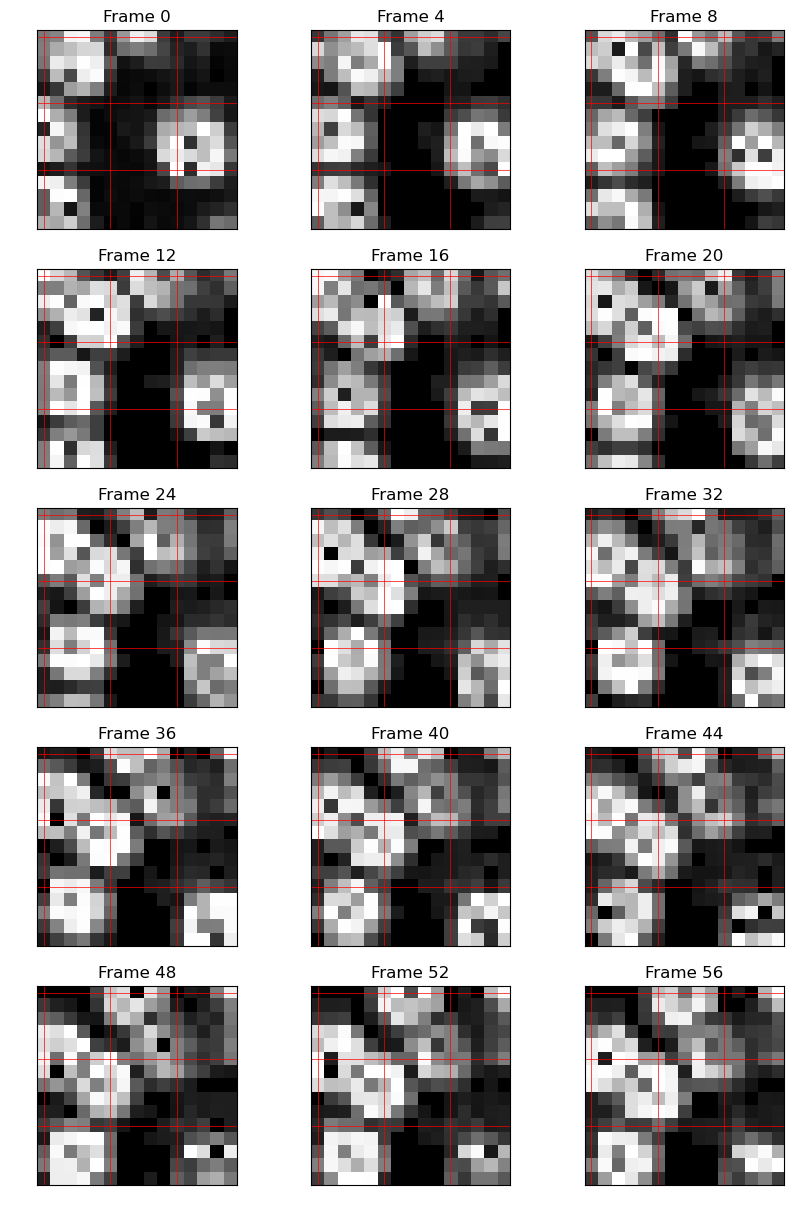

In [21]:
num_images = 15
texture=np.random.randint(0,100)
images = data.X[texture][0:15]

num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()
ax = axes[0]
ax.set_title("Frame "+str(0))
ax.imshow(images[0][50:65,50:65], cmap='gray')
ax.set_xticks(np.arange(0, 15, 5))
# Set custom ticks for y-axis (every 10 units)
ax.set_yticks(np.arange(0, 15, 5))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
# Plot each image
imageA=images[0].astype(np.uint8)
kernel=np.array((9,9))
for i in range(1,num_images):
    imageB=images[i].astype(np.uint8)
    imageB[imageB<20]=0

    ax = axes[i]
    ax.imshow(imageB[50:65,50:65],cmap="gray")
    #ax.axis('off')
    ax.set_xticks(np.arange(0, 15, 5))
    # Set custom ticks for y-axis (every 10 units)
    ax.set_yticks(np.arange(0, 15, 5))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
    ax.set_title("Frame "+str(i*4))
    

# Remove any empty subplots
for i in range(num_images, num_rows*num_cols):
    fig.delaxes(axes[i])

plt.suptitle("Flow of "+str(data.keys[data.y[texture]]))
plt.tight_layout()
plt.savefig("/its/home/drs25/Pictures/TacTip real/rigData/centrepointMove.pdf")
plt.show()

## Look at spread of changes

In [30]:
#change=[np.zeros((len(data.X[0]))) for i in range(len(data.keys))]
change=np.zeros((len(data.X),41,20))
counter=[0 for i in range(len(data.keys))]
for i in range(len(data.X)):
    y=data.y[i]
    framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
    framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
    difference=np.abs(np.sum(framesA-framesB,axis=1))
    change[y][counter[y]]=difference
    counter[y]+=1

change=(np.array(change).T/np.array(counter)).T
change.shape

IndexError: list index out of range

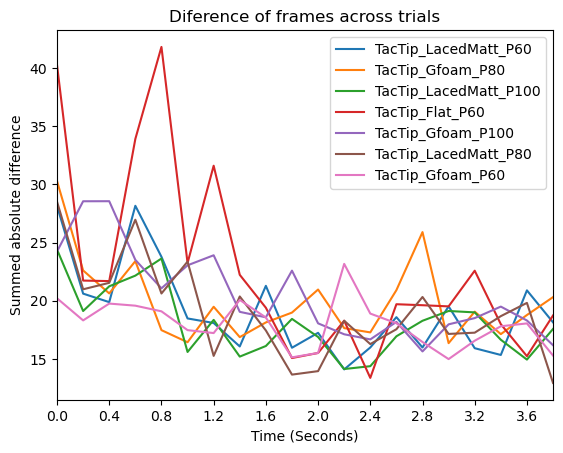

In [ ]:
av=np.average(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

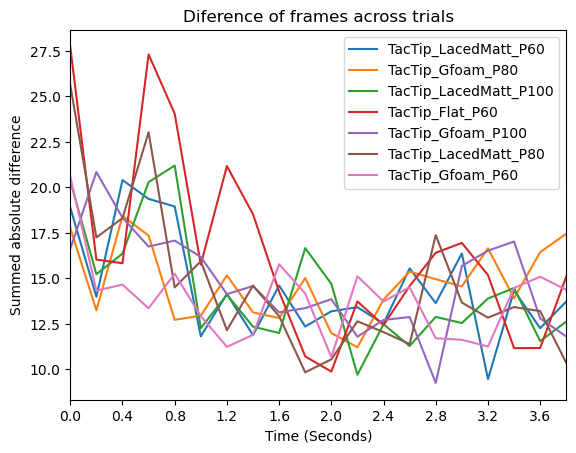

In [318]:
av=np.std(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

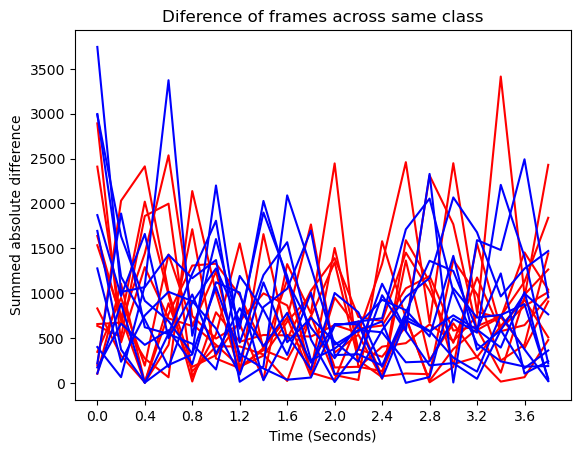

In [296]:
found=0
i=0
while found<10:
    y=data.y[i]
    if y==0:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="r")
        found+=1
    i+=1
i=0
found=0
while found<10:
    y=data.y[i]
    if y==5:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="b")
        found+=1
    i+=1

plt.xticks([i for i in range(0,len(change[0]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[0]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across same class")
plt.show()
    

# Machine learning
## Regression
### Ridge

In [8]:
from sklearn.linear_model import Ridge

In [5]:
reformed_X=data.X.reshape(4800,20*110*120) 
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [6]:
alpha = 1.0  # Regularization parameter

# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(train_X, train_y)
predictions = ridge_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.7611111111111111 %
average loss 0.2388888888888889


In [10]:
# t exp
alpha = 1.0 
t_ridge_train=[]
t_ridge_test=[]
for i in range(7,21,1):
    d=data.X[:,6:i]
    reformed_X=d.reshape(4800,(i-6)*110*120) 
    train_X=reformed_X[:2000]
    train_y=data.y[0:2000]
    test_X=reformed_X[2000:2900]
    test_y=data.y[2000:2900]
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(train_X, train_y)
    predictionsX = ridge_model.predict(train_X)
    predictions = ridge_model.predict(test_X)
    t_ridge_train.append((len(predictionsX)-np.sum(np.absolute(np.absolute(np.round(predictionsX)-train_y))))/len(predictionsX))
    t_ridge_test.append((len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions))
    del d
    del train_X
    del test_X
t_ridge_test=np.array(t_ridge_test)
t_ridge_train=np.array(t_ridge_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_train",t_ridge_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_test",t_ridge_test)

In [14]:
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.6122222222222222 %
average loss 0.3877777777777778


### Linear

In [7]:
from sklearn.linear_model import LinearRegression

In [16]:
reformed_X=data.X.reshape(4800,20*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [8]:
linear_model = LinearRegression()

# Fit the model
linear_model.fit(train_X, train_y)
predictions = linear_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.7588888888888888 %
average loss 0.2411111111111111


In [5]:
# t exp
t_lin_train=[]
t_lin_test=[]
for i in range(1,21,1):
    d=data.X[:,0:i]
    reformed_X=d.reshape(4800,i*110*120) 
    train_X=reformed_X[:2000]
    train_y=data.y[0:2000]
    test_X=reformed_X[2000:2900]
    test_y=data.y[2000:2900]
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
    predictionsX = linear_model.predict(train_X)
    predictions = linear_model.predict(test_X)
    t_lin_train.append((len(predictionsX)-np.sum(np.absolute(np.absolute(np.round(predictionsX)-train_y))))/len(predictionsX))
    t_lin_test.append((len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions))
    del d
    del train_X
    del test_X
    del linear_model
t_lin_test=np.array(t_lin_test)
t_lin_train=np.array(t_lin_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_train",t_lin_train)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_test",t_lin_test)

### Random forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
reformed_X=data.X.reshape(4800,20*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [17]:
# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)

# Fit the model
rf_model.fit(train_X, train_y)

predictions = rf_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.7411111111111112 %
average loss 0.2588888888888889


### Visualising regression

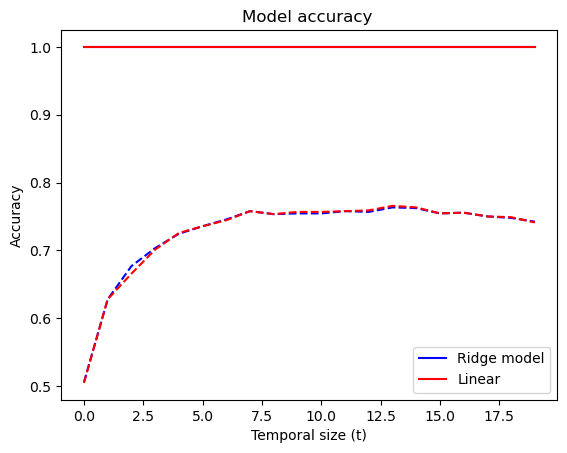

In [12]:
t_ridge_test=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_test.npy")
t_ridge_train=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_ridge_train.npy")
t_lin_test=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_test.npy")
t_lin_train=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/t_lin_train.npy")
plt.plot(t_ridge_train,c="b",label="Ridge model")
plt.plot(t_ridge_test,"--",c="b")
plt.plot(t_lin_train,c="r",label="Linear")
plt.plot(t_lin_test,"--",c="r")
plt.legend(loc="lower right")
plt.xlabel("Temporal size (T)")
plt.ylabel("Accuracy")
plt.title("Model accuracy ")
plt.show()

In [34]:
reformed_X=data.X[:,:7].reshape(4800,7*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)
alpha = 1.0  # Regularization parameter

#create best models
print("RF")
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
rf_model.fit(train_X, train_y)
print("LR")
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)
print("RR")
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(train_X, train_y)

#predictions
predictionsA = np.round(rf_model.predict(test_X))
predictionsB = np.round(linear_model.predict(test_X))
predictionsC = np.round(ridge_model.predict(test_X))

(900, 92400) (2000, 92400)
RF


In [24]:
a=predictionsA-test_y
correct=len(a[a==0])
print("Accuracy",correct/len(a))

a=predictionsB-test_y
correct=len(a[a==0])
print("Accuracy",correct/len(a))

a=predictionsB-test_y
correct=len(a[a==0])
print("Accuracy",correct/len(a))

Accuracy 0.8422222222222222
Accuracy 0.7933333333333333
Accuracy 0.7933333333333333


0 16
1 16
2 16
3 16
4 16
5 16
6 16
7 16
8 16
0 27
1 27
2 27
3 27
4 27
5 27
6 27
7 27
8 27
0 16
1 16
2 16
3 16
4 16
5 16
6 16
7 16
8 16
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
0 14
1 14
2 14
3 14
4 14
5 14
6 14
7 14
8 14
0 16
1 16
2 16
3 16
4 16
5 16
6 16
7 16
8 16
0 14
1 14
2 14
3 14
4 14
5 14
6 14
7 14
8 14
0 27
1 27
2 27
3 27
4 27
5 27
6 27
7 27
8 27
0 14
1 14
2 14
3 14
4 14
5 14
6 14
7 14
8 14
0 22
1 22
2 22
3 22
4 22
5 22
6 22
7 22
8 22
0 21
1 21
2 21
3 21
4 21
5 21
6 21
7 21
8 21
0 16
1 16
2 16
3 16
4 16
5 16
6 16
7 16
8 16
0 24
1 24
2 24
3 24
4 24
5 24
6 24
7 24
8 24
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
0 21
1 21
2 21
3 21
4 21
5 21
6 21
7 21
8 21
0 21
1 21
2 21
3 21
4 21
5 21
6 21
7 21
8 21
0 21
1 21
2 21
3 21
4 21
5 21
6 21
7 21
8 21
0 22
1 22
2 22
3 22
4 22
5 22
6 22
7 22
8 22
0 20
1 20
2 20
3 20
4 20
5 20
6 20
7 20
8 20
0 27
1 27
2 27
3 27
4 27
5 27
6 27
7 27
8 27
0 27
1 27


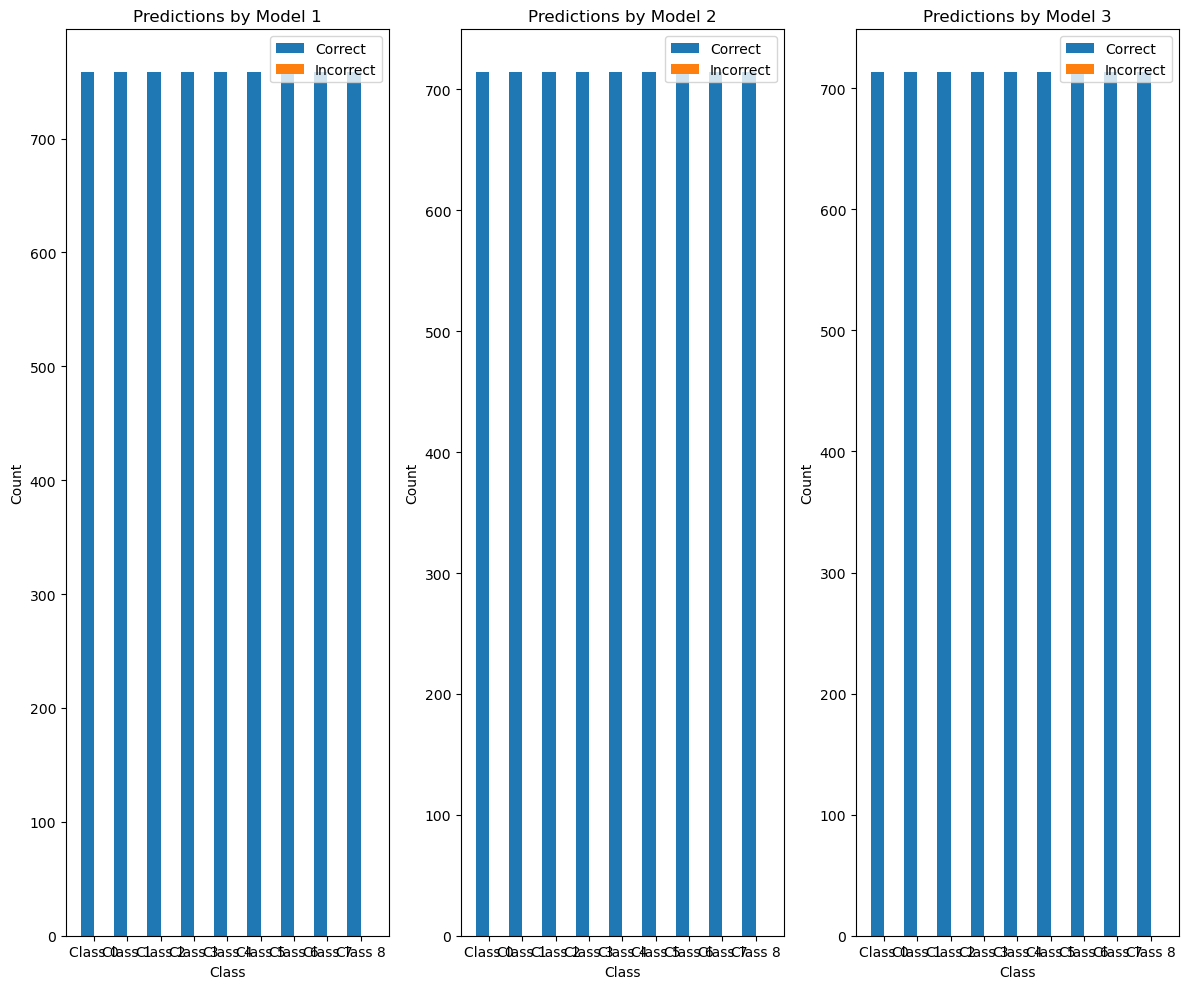

In [28]:
#show histogram
# Combine all predictions
predictions = [predictionsA, predictionsB, predictionsC]
model_names = ['Model 1', 'Model 2', 'Model 3']
num_models = len(predictions)
num_classes = len(np.unique(test_y))

# Prepare data for the histograms
correct_counts = np.zeros((num_models, num_classes))
incorrect_counts = np.zeros((num_models, num_classes))

for i, preds in enumerate(predictions):
    for k in range(len(test_y)):
        for cls in range(num_classes):
            if test_y[k]==preds[k]:
                correct_counts[i, cls] +=1
            elif test_y[k]!= preds[k] and data.files.index(data.keys[test_y[k]])==cls:
                incorrect_counts[i, cls] +=1
            else:
                print(cls,test_y[k])
print(incorrect_counts)
print(correct_counts)
# Plotting
fig, axes = plt.subplots(1, num_models, figsize=(12, 10 ))

for i in range(num_models):
    ax = axes[i] if num_models > 1 else axes
    width = 0.4
    indices = np.arange(num_classes)
    
    ax.bar(indices - width/2, correct_counts[i], width, label='Correct')
    ax.bar(indices + width/2, incorrect_counts[i], width, label='Incorrect')
    
    ax.set_title(f'Predictions by {model_names[i]}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_xticks(indices)
    ax.set_xticklabels([f'Class {j}' for j in range(num_classes)])
    ax.legend()

plt.tight_layout()
plt.show()